# null hypothesis: There is no difference in similarities of documents analyzed through by Doc2Vec and Word2Vec
# alternate hypothesis: There are differences in similarities of documents  analyzed through Doc2Vec and Word2Vec

In [3]:
import pandas as pd

In [4]:
from gensim.models import doc2vec
from gensim.models import word2vec

In [5]:
def label_sentence(sentence, label):
    return doc2vec.LabeledSentence(words=sentence, tags=[label])

In [6]:
df = pd.read_csv("./billboard.csv",encoding="latin")

In [7]:
df = df.dropna()
df = df[df['Lyrics']!="instrumental"]

In [8]:
df.drop('Rank',axis=1)
df = df.reset_index(drop=True)

# Preparing Labelled Sentences for training Doc2Vec

In [9]:
docs = []
for i in range(len(df)):
    row = df.iloc[i]
    lyrics = row['Lyrics']
    if(lyrics != "instrumental"):
        docs.append(label_sentence(lyrics,str(i)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


# Training Doc2Vec and Word2Vec on same set of Lyrics (Billboard songs 1965 - 2015)

In [10]:
d2v = doc2vec.Doc2Vec(docs, size=300, window=8, min_count=5, workers=4)
w2v = word2vec.Word2Vec(df['Lyrics'].apply(lambda x:x.split(" ")), size=300, window= 8, min_count=5,workers=4)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [11]:
d2v_sim = [None]*len(df)
for i,d in d2v.docvecs.most_similar("2178",topn=len(df)):
    d2v_sim[int(i)] = d

# Adding Doc2Vec similarity of Rick Roll lyrics to lyrics of all other songs to data frame column 

In [12]:
df['d2v_similarity']=d2v_sim

In [13]:
def getWord2VecSentenceVector(sentence):
    sentence = sentence.split(" ")
    vector = None
    i = 0
    for word in sentence:
        try:
            v = w2v[word]
            if(vector is None):
                vector = v
                i+=1
            else:
                vector =vector+v
        except:
            continue
    vector /= i
    return vector

# Adding Word2Vec similarity of Rick Roll lyrics to lyrics of all other songs to data frame column 

In [14]:
df['w2v_vector'] = df['Lyrics'].apply(getWord2VecSentenceVector)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [15]:
from scipy.spatial.distance import cosine
rick_roll = getWord2VecSentenceVector(df.iloc[2178]['Lyrics'])
df['w2v_similarity'] = df['w2v_vector'].apply(lambda x:cosine(x,rick_roll))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [16]:
import matplotlib.pyplot as plt

Text(0.5,1,'Year vs Difference in Similarity between W2V and D2V')

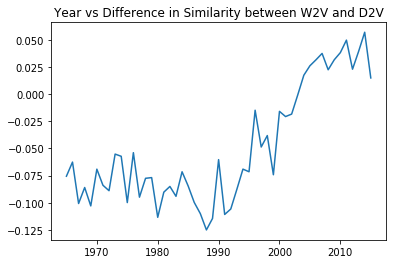

In [103]:
plt.plot(df.groupby("Year").mean().index,df.groupby("Year").mean()['w2v_similarity']-df.groupby("Year").mean()['d2v_similarity'])
plt.title("Year vs Difference in Similarity between W2V and D2V")

Text(0.5,1,'W2V Similarity with Rickroll vs Years')

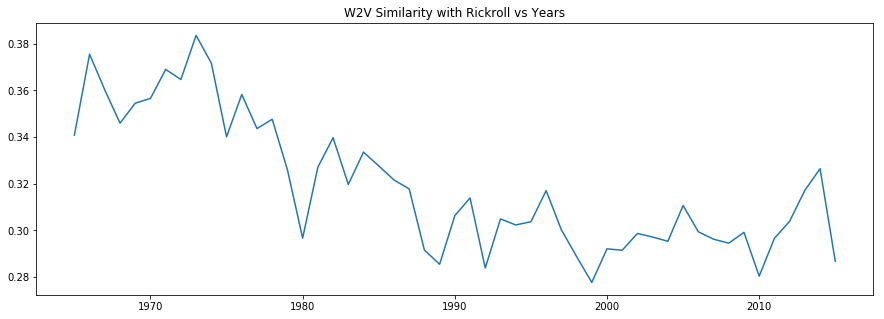

In [115]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean()['w2v_similarity'])
plt.title("W2V Similarity with Rickroll vs Years")

Text(0.5,1,'D2V Similarity with Rickroll vs Years')

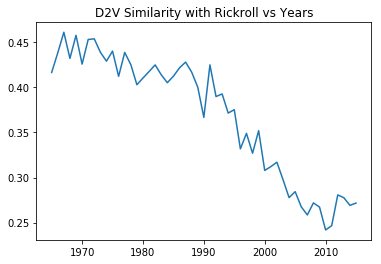

In [114]:
plt.plot(df.groupby("Year").mean()['d2v_similarity'])
plt.title("D2V Similarity with Rickroll vs Years")

# Finding number of songs where Doc2Vec and Word2Vec share cosine similarity within 10% range

In [108]:
num_similar_songs = len([x for x in (df['d2v_similarity']-df['w2v_similarity']).apply(lambda x:abs(x)) if x <= 0.1])

In [109]:
total_num_songs = len(df)

In [110]:
num_similar_songs/total_num_songs

0.28358513679052677

In [24]:
from annoy import AnnoyIndex

In [25]:
w2v_cluster = AnnoyIndex(300,metric='angular')

In [26]:
for i in range(len(df)):
    row = df.iloc[i]
    vector = row['w2v_vector']
    w2v_cluster.add_item(i,vector)

In [27]:
w2v_cluster.build(100)

True

# showing top 10 most similar songs to Rick Roll using Word2Vec

In [28]:
for i in w2v_cluster.get_nns_by_vector(rick_roll,10):
    print(df.iloc[i]['Song'])
    print()
    print(df.iloc[i]['Lyrics'])
    print()

never gonna give you up

 ooh oohwere no strangers to love you know the rules and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wanna tell you how im feeling gotta make you understandnever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youweve known each other for so long your hearts been aching but youre too shy to say it inside we both know whats been going on we know the game and were gonna play it and if you ask me how im feeling dont tell me youre too blind to seenever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt younever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youooh give you up ooh gi

# showing top 10 most similar songs to Rick Roll using Doc2Vec

In [29]:
for i,d in d2v.docvecs.most_similar("2178",topn=10):
    print(df.iloc[int(i)]['Song'])
    print()
    print(df.iloc[int(i)]['Lyrics'])
    print()

jumper

 i wish you would step back from that ledge my friend you could cut ties with all the lies that youve been living in and if you do not want to see me again i would understand i would understand the angry boy a bit too insane icing over a secret pain you know you dont belong youre the first to fight youre way too loud youre the flash of light on a burial shroud i know somethings wrong well everyone i know has got a reason to say put the past away i wish you would step back from that ledge my friend you could cut ties with all the lies that youve been living in and if you do not want to see me again i would understand i would understand well hes on the table and hes gone to code and i do not think anyone knows what they are doing here and your friends have left youve been dismissed i never thought it would come to this and i i want you to know everyones got to face down the demons maybe today we can put the past away i wish you would step back from that ledge my friend you could 

# Use chi-square test to show that the difference between Doc2Vec and Word2Vec are not the same

In [45]:
from scipy.stats import chisquare

In [61]:
df2 = df.dropna()

In [58]:
chisquare(f_obs=df2['d2v_similarity'],f_exp=df2['w2v_similarity'],ddof=len(df2)-1)

Power_divergenceResult(statistic=1020.2148196925884, pvalue=nan)

In [51]:
len(df2)

4897

In [62]:
df2['d2v_similarity'] = df2['d2v_similarity'].apply(lambda x:round(x,2))
df2['w2v_similarity'] = df2['w2v_similarity'].apply(lambda x:round(x,2))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Doc2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

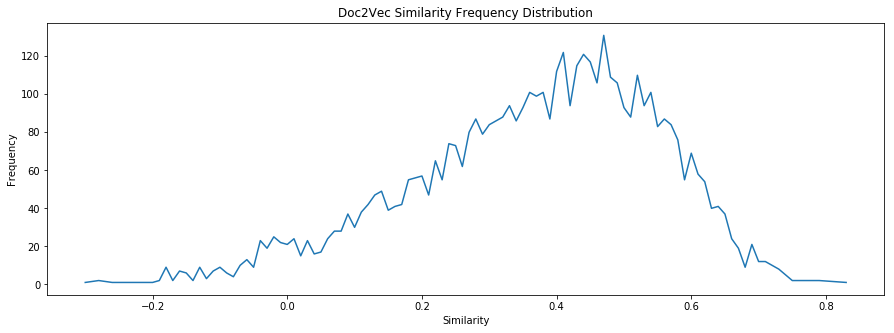

In [88]:
plt.figure(figsize=(15,5))
plt.plot(df2.groupby('d2v_similarity').count()['Rank'])
plt.title("Doc2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# Word2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

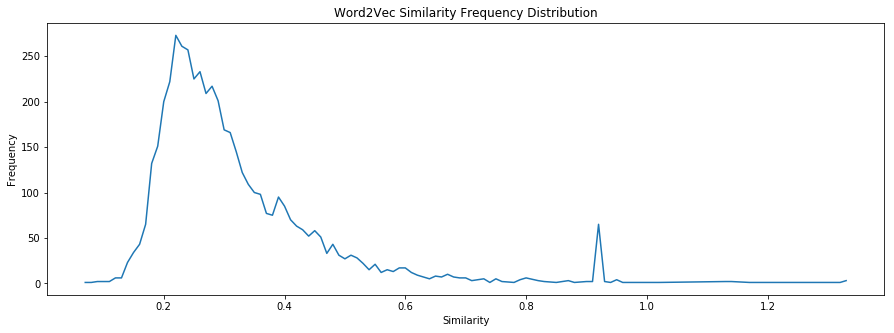

In [89]:
plt.figure(figsize=(15,5))
plt.plot(df2.groupby('w2v_similarity').count()['Rank'])
plt.title("Word2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")